# 📈 Value at Risk (VaR)

El **Value at Risk (VaR)** es una de las métricas más importantes en la gestión de riesgos financieros. En esencia, es una técnica estadística que responde a una pregunta clave:

> **¿Cuál es la máxima pérdida** que puedo esperar en mi portafolio, dentro de un periodo de tiempo y con un cierto nivel de confianza?

En lugar de dar un número absoluto, el VaR nos da una **estimación probabilística** de la pérdida potencial.

---

## 💡 Un ejemplo para entenderlo

La mejor forma de entenderlo es con un ejemplo práctico.

Imagina que el "VaR de tu portafolio a 1 día, con un 95% de confianza, es de 10.000 €".

Esto significa que:
* Tienes un **95% de certeza** de que, en el transcurso del próximo día, tus pérdidas **no superarán** los 10.000 €.
* Visto de otra forma, solo existe un **5% de probabilidad** de que sufras una pérdida *mayor* a 10.000 € en ese día.

El VaR, por tanto, cuantifica el riesgo de "cola", es decir, esos eventos poco probables pero muy costosos.

---

## 🧮 Un poco de rigurosidad matemática

Desde un punto de vista formal, el VaR es un **cuantil** de la distribución de pérdidas y ganancias.

<img src="https://d1rwhvwstyk9gu.cloudfront.net/2022/06/Value-at-Risk-VaR-portfolio.png" alt="Gráfico de VaR" width="300">

Definimos $X$ como la variable aleatoria que representa el rendimiento (ganancia/pérdida) de la cartera en el horizonte temporal deseado.

Si establecemos $1 - \alpha$ como nuestro **nivel de confianza** (ej: 0.95 o 0.99), entonces $\alpha$ es el **nivel de significancia** (ej: 0.05 o 0.01).

El Value at Risk se define formalmente como:

$$
\text{VaR}_\alpha (X) = -\inf\{x \in \mathbb{R} \mid P(X \le x) > \alpha\}
$$

En términos más sencillos:
1.  Buscamos el valor $x$ (que será una pérdida, por tanto, negativo).
2.  Este $x$ es el punto donde la probabilidad de tener una pérdida *peor* que él ($X \le x$) es exactamente $\alpha$.

## Como calcular el VaR con Python

Existen tres metodos diferentes para calcularlo:
1.   Histórico
2.   Método Paramétrico  (Varianza-Covarianza)
3.   Método de Monte Carlo



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# descargamos los datos historicos de AAPL
ticker = "AAPL"
data = yf.download(ticker, start="2017-01-01", end="2025-01-01",group_by = "ticker",auto_adjust = True, progress = False)[ticker]
#calculamos los returns
returns = data['Close'].pct_change().dropna().to_numpy()

### 1️⃣ Método Histórico.
Este método es el mas sencillo e intuitivo, no vamos a asumir que los datos siguien ningún tipo de distribución, tan solo buscamos el percentil que nos interese en nuestra serie de datos.


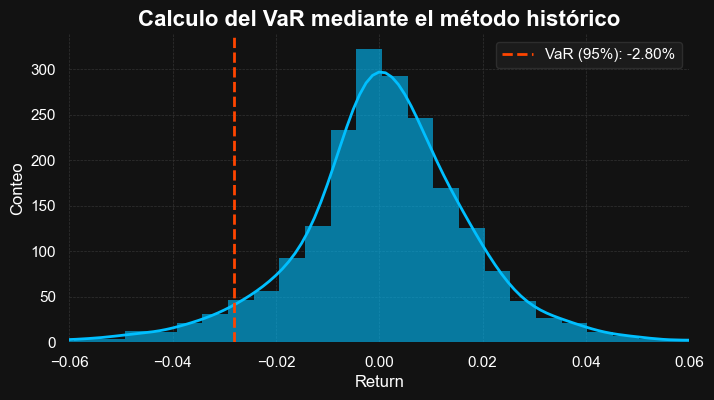

In [2]:
# definimos un intervalo de confianza del 95
confidence_level = 0.95
# calculamos el valor que le corresponde a dicho percentil
VaR_historical = np.percentile(returns, (1 - confidence_level) * 100)

##########################
####  HACEMOS EL PLOT ####
##########################

plt.style.use('dark_background')
sns.set_theme(style="dark", rc={"axes.facecolor": "#121212", "figure.facecolor": "#121212", "grid.color": "#333333", "text.color": "white", "xtick.color": "white", "ytick.color": "white", "axes.labelcolor": "white"})

plt.figure(figsize=(8, 4))

sns.histplot(
    x=returns,
    kde=True,
    bins=50,
    color="#00BFFF", 
    alpha=0.6,
    edgecolor="none",
    line_kws={'linewidth': 2, 'color': '#FFD700'} 
)

plt.axvline(
    x=VaR_historical,
    color='#FF4500', 
    linestyle='--',
    linewidth=2,
    label=f'VaR (95%): {VaR_historical:.2%}'
)

plt.xlim(-0.06, 0.06)

plt.title("Calculo del VaR mediante el método histórico", fontsize=16, color='white', weight='bold')
plt.xlabel("Return", fontsize=12, color='white')
plt.ylabel("Conteo", fontsize=12, color='white')

legend = plt.legend(facecolor='#1E1E1E', edgecolor='#333333')
for text in legend.get_texts():
    text.set_color("white")

sns.despine(left=True, bottom=True)
plt.grid(color='#333333', linestyle='--', linewidth=0.5)

plt.show()

### 2️⃣ Método Paramétrico (Varianza - Covarianza)
En este caso vamos a usar que los rendimientos del activo siguen una distribución normal, es decir $X \equiv N(\mu,\sigma)$ y por tanto podemos calcular cual el rentimiento del percentil $\alpha$ con la formula:
$$
R_{\alpha} = \mu + Z_{\alpha} \cdot \sigma
$$

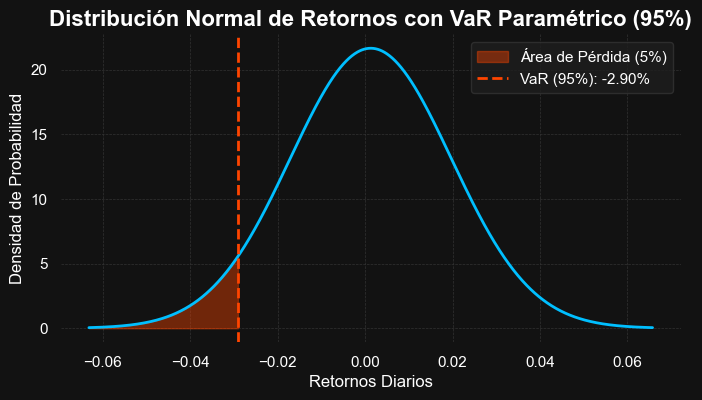

In [3]:
from scipy.stats import norm
# calculamos la media y la desviacion estandar de nuestros datos
mean_return = np.mean(returns)
std_dev = np.std(returns)

# calculamos el VaR al 95% confianza utilzando el Z-score
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)
VaR_variance_covariance = mean_return + z_score * std_dev

##########################
####  HACEMOS EL PLOT ####
##########################

plt.style.use('dark_background')
sns.set_theme(style="dark", rc={
    "axes.facecolor": "#121212", 
    "figure.facecolor": "#121212", 
    "grid.color": "#333333", 
    "text.color": "white", 
    "xtick.color": "white", 
    "ytick.color": "white", 
    "axes.labelcolor": "white"
})
plt.figure(figsize=(8, 4)) 
x = np.linspace(mean_return - 3.5 * std_dev, mean_return + 3.5 * std_dev, 1000)
y = norm.pdf(x, mean_return, std_dev)
plt.plot(x, y,
         color="#00BFFF", 
         linewidth=2)
plt.fill_between(x, 0, y,
                 where=(x <= VaR_variance_covariance),
                 color='#FF4500',
                 alpha=0.4,
                 label='Área de Pérdida (5%)')
plt.axvline(VaR_variance_covariance,
            color='#FF4500', 
            linestyle='--',
            linewidth=2,
            label=f'VaR (95%): {VaR_variance_covariance:.2%}')
plt.title(f'Distribución Normal de Retornos con VaR Paramétrico (95%)', fontsize=16, color='white', weight='bold')
plt.xlabel('Retornos Diarios', fontsize=12, color='white')
plt.ylabel('Densidad de Probabilidad', fontsize=12, color='white')
legend = plt.legend(loc='upper right', frameon=True, facecolor='#1E1E1E', edgecolor='#333333')
for text in legend.get_texts():
    text.set_color("white")
sns.despine(left=True, bottom=True)
plt.grid(color='#333333', linestyle='--', linewidth=0.5)

plt.show()

### 3️⃣ Método de Monte Carlo

Monte Carlo VaR (95% confidence level): -2.89%


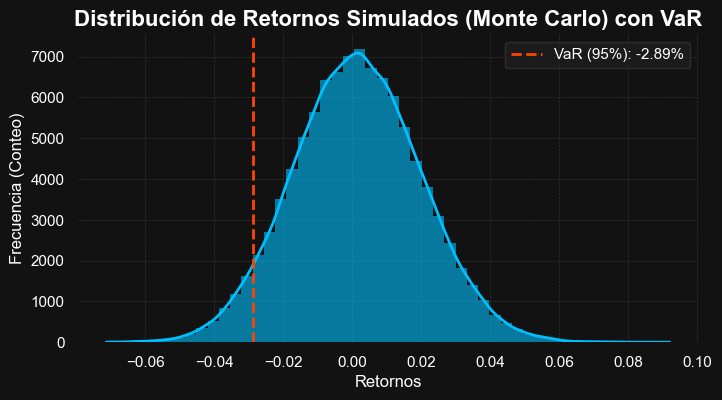

In [6]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# simulamos retornos futuros usando Monte Carlo
num_simulations = 100000
simulated_returns = np.random.normal(np.mean(returns), np.std(returns), num_simulations)

# calculamos los valores finales de portfolio
portfolio_values =  np.exp(simulated_returns) - 1

# calculamos el VaR
confidence_level = 0.95
VaR_monte_carlo = np.percentile(portfolio_values, (1 - confidence_level) * 100)

print(f"Monte Carlo VaR (95% confidence level): {VaR_monte_carlo:.2%}")

##########################
####  HACEMOS EL PLOT ####
##########################

plt.style.use('dark_background')
sns.set_theme(style="dark", rc={
    "axes.facecolor": "#121212",
    "figure.facecolor": "#121212",
    "grid.color": "#333333",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "axes.labelcolor": "white"
})
plt.figure(figsize=(8, 4))
sns.histplot(
    x=portfolio_values,
    kde=True,
    bins=50,
    color="#00BFFF",  
    alpha=0.6,
    edgecolor="none",
    line_kws={'linewidth': 2, 'color': '#FFD700'} 
)
plt.axvline(
    x=VaR_monte_carlo,
    color='#FF4500',  
    linestyle='--',
    linewidth=2,
    label=f'VaR (95%): {VaR_monte_carlo:.2%}'
)
plt.title('Distribución de Retornos Simulados (Monte Carlo) con VaR', fontsize=16, color='white', weight='bold')
plt.xlabel('Retornos', fontsize=12, color='white')
plt.ylabel('Frecuencia (Conteo)', fontsize=12, color='white')
legend = plt.legend(facecolor='#1E1E1E', edgecolor='#333333')
for text in legend.get_texts():
    text.set_color("white")
sns.despine(left=True, bottom=True) 
plt.grid(color='#333333', linestyle='--', linewidth=0.5) 
plt.show()

# 🎯 Ejemplo Práctico (Cartera de las 7 Magníficas)

In [1]:
import yfinance as yf
import numpy as np
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# definimos los tickers de las 7 magnificas
tickers = ["AAPL","NVDA","TSLA","META","GOOG","AMZN","MSFT"]

# descargamos los datos de cierre desde el 17
data = yf.download(tickers, start="2017-01-01",auto_adjust = True,progress = False)["Close"]

# rellenamos los posibles datos nulos
data = data.ffill()

# calculamos log returns
log_returns = np.log(data.pct_change().dropna() + 1)

In [2]:
def calculate_montecarlo_var(prev_data, horizon, sims, weights, confidence_level=0.95):
    # calculamos la matriz de covarianza de la ventana (media exponencial ponderada)
    cov_matrix = prev_data.ewm(span=30).cov().iloc[-len(weights):].values
    
    # matriz de cholesky
    L = np.linalg.cholesky(cov_matrix)
    
    # inicializamos una matriz de dimension nºsims x nºtickers
    sim_prices = np.ones((sims, len(weights)))
    
    # Grados de libertad
    df = 5

    # simulamos día a día hasta el horizonte
    for _ in range(horizon):
        # generamos variables aleatorias t-Student y divimos entre la desviación estándar de la distribución t-Student
        Z = np.random.standard_t(df, size=(sims, len(weights))) / np.sqrt(df / (df - 2))
        
        # multiplicamos por la matriz de cholesky
        daily_log_returns = Z @ L.T
        
        # simulamos los precios
        sim_prices = sim_prices * np.exp(daily_log_returns)
    
    # Retorno acumulado simulado
    simulated_returns = sim_prices @ weights - 1
    
    # Calculamos VaR
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return var_value

Iniciando Backtest semanal (Ventana: 30 días)...

RESULTADOS DEL BACKTEST
Total Semanas Analizadas: 440
Excepciones (Breaches):   19
Tasa de Fallo Real:       4.32%
Tasa Esperada (1-Conf):   5.00%
CONCLUSIÓN: El modelo está bien CALIBRADO.


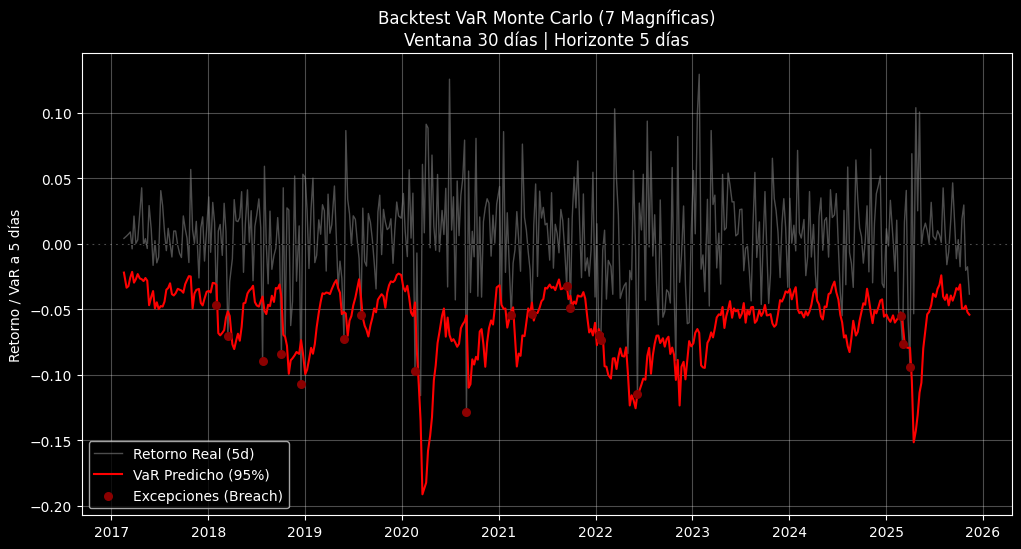

In [3]:
# PARAMETROS DEL BACKTEST
window_size = 30   # 30 días de lookback
forecast_horizon = 5 # predecimos los siguientes 5 días
confidence_level = 0.95
n_simulations = 1000
N_tickers = len(tickers)
weights = np.ones(N_tickers) / N_tickers # equiponderado

# listas para guardar resultados
backtest_dates = []
var_predictions = []
actual_returns = []
breaches = [] # 1 si rompió el VaR, 0 si no

# añadimos semilla para reproducibilidad
np.random.seed(42)

print(f"Iniciando Backtest semanal (Ventana: {window_size} días)...")

# buscamos comenzar en los precios de cierre del dia viernes
start_index = window_size
while log_returns.index[start_index].date().weekday() != 4:
    start_index += 1

for i in range(start_index, len(log_returns) - forecast_horizon, 5): 
    # seleccionamos la ventana de referencia
    train_window = log_returns.iloc[i-window_size : i]

    # tomamos el precio mas reciente conocido (día i)
    current_prices = data.iloc[i].values 
    
    # calculamos el VaR
    predicted_var = calculate_montecarlo_var(
        train_window, forecast_horizon, n_simulations, weights
    )
    
    # calculamos la variacion real
    price_t = data.iloc[i] @ weights # precio de la cartera en el dia i
    price_t_plus_5 = data.iloc[i + forecast_horizon] @ weights # precio de la cartera en el dia i + 5
    actual_ret_5d = (price_t_plus_5 / price_t) - 1 # variacion real
    
    # guardamos datos
    date = log_returns.index[i]
    backtest_dates.append(date)
    var_predictions.append(predicted_var)
    actual_returns.append(actual_ret_5d)
    
    # comprobamos si fallo el modelo
    if actual_ret_5d < predicted_var:
        breaches.append(1)
    else:
        breaches.append(0)

# resultados
breach_rate = np.mean(breaches)
target_rate = 1 - confidence_level

print("\n" + "="*40)
print("RESULTADOS DEL BACKTEST")
print("="*40)
print(f"Total Semanas Analizadas: {len(backtest_dates)}")
print(f"Excepciones (Breaches):   {sum(breaches)}")
print(f"Tasa de Fallo Real:       {breach_rate:.2%}")
print(f"Tasa Esperada (1-Conf):   {target_rate:.2%}")

if breach_rate > target_rate + 0.02:
    print("CONCLUSIÓN: El modelo SUBESTIMA el riesgo (demasiadas pérdidas no previstas).")
elif breach_rate < target_rate - 0.02:
    print("CONCLUSIÓN: El modelo es muy CONSERVADOR (sobreestima el riesgo).")
else:
    print("CONCLUSIÓN: El modelo está bien CALIBRADO.")

# Gráfico
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(backtest_dates, actual_returns, label="Retorno Real (5d)", color="grey", alpha=0.6, linewidth=1)
plt.plot(backtest_dates, var_predictions, label="VaR Predicho (95%)", color="red", linewidth=1.5)

# Resaltar los puntos donde fallamos
breach_dates = [backtest_dates[i] for i in range(len(breaches)) if breaches[i] == 1]
breach_vals = [actual_returns[i] for i in range(len(breaches)) if breaches[i] == 1]
plt.scatter(breach_dates, breach_vals, color="darkred", s=30, label="Excepciones (Breach)", zorder=5)

plt.title(f"Backtest VaR Monte Carlo (7 Magníficas)\nVentana 30 días | Horizonte 5 días")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.ylabel("Retorno / VaR a 5 días")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

¿ Cuanto pueden caer las 7 magnificas la semana que viene?

In [11]:
VaR = calculate_montecarlo_var(log_returns.iloc[-30:], 5, 1000, weights)
print(f"En un 95% de confianza, el VaR es de {VaR:.2%}")

En un 95% de confianza, el VaR es de -5.43%
